In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data_origin=pd.read_csv("../input/train.csv")
test_data_origin=pd.read_csv("../input/test.csv")

In [3]:
train_data_origin.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
print("Train: X =",train_data_origin.shape)
print("Test: X =",test_data_origin.shape)

Train: X = (42000, 785)
Test: X = (28000, 784)


In [5]:
train_features,train_labels = train_data_origin.drop("label",axis=1).values.astype('float32'),train_data_origin["label"].values.astype('int32') 
test_features = test_data_origin.values.astype('float32')

In [6]:
print("Train: X =",train_features.shape,"Y =",train_labels.shape)
print("Test: X =",test_features.shape)

Train: X = (42000, 784) Y = (42000,)
Test: X = (28000, 784)


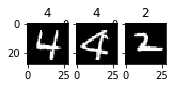

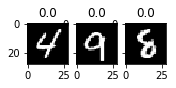

In [7]:
import random
train_features_images=train_features.reshape(train_features.shape[0],28,28)
test_features_images=test_features.reshape(test_features.shape[0],28,28)

def show_images(features_images,labels,length):
    start=42
    for i in range(start, start+length):
        plt.subplot(330 + (i+1))
        plt.imshow(features_images[i], cmap=plt.get_cmap('gray'))
        plt.title(labels[i])
    plt.show()
        
show_images(train_features_images,train_labels,3)
show_images(test_features_images,np.zeros(test_features_images.shape[0]),3)

In [8]:
mean_px = train_features.mean().astype(np.float32)
std_px = train_features.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

train_features_norm=standardize(train_features)
test_features_norm=standardize(test_features)

In [9]:
train_features_norm[:5]

array([[-0.42463091, -0.42463091, -0.42463091, ..., -0.42463091,
        -0.42463091, -0.42463091],
       [-0.42463091, -0.42463091, -0.42463091, ..., -0.42463091,
        -0.42463091, -0.42463091],
       [-0.42463091, -0.42463091, -0.42463091, ..., -0.42463091,
        -0.42463091, -0.42463091],
       [-0.42463091, -0.42463091, -0.42463091, ..., -0.42463091,
        -0.42463091, -0.42463091],
       [-0.42463091, -0.42463091, -0.42463091, ..., -0.42463091,
        -0.42463091, -0.42463091]], dtype=float32)

In [10]:
train_features_reshaped=train_features_norm.reshape(train_features_norm.shape[0],28,28,1)
test_features_reshaped=test_features_norm.reshape(test_features_norm.shape[0],28,28,1)

train_labels_reshaped=train_labels.reshape(train_features.shape[0],1)
train_labels_reshaped=np.eye(10)[train_labels]

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(train_features_reshaped, train_labels_reshaped, test_size=0.10)
X_test=test_features_reshaped

In [12]:
print("Train: X =",X_train.shape,"Y =",y_train.shape)
print("Validation: X =",X_validation.shape,"Y =",y_validation.shape)

Train: X = (37800, 28, 28, 1) Y = (37800, 10)
Validation: X = (4200, 28, 28, 1) Y = (4200, 10)


In [14]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=X_train.shape[1:]))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(10, activation='softmax'))
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        2080      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 64)          8256      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 576)               0         
__________

In [15]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', 
                  metrics=['accuracy'])

In [16]:
from keras.callbacks import ModelCheckpoint   

# train the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)
hist = model.fit(X_train, y_train, batch_size=32, epochs=30,
          validation_data=(X_validation, y_validation), callbacks=[checkpointer], 
          verbose=2, shuffle=True)

Train on 37800 samples, validate on 4200 samples
Epoch 1/30
Epoch 00000: val_loss improved from inf to 0.08115, saving model to model.weights.best.hdf5
6s - loss: 0.1862 - acc: 0.9412 - val_loss: 0.0812 - val_acc: 0.9776
Epoch 2/30
Epoch 00001: val_loss improved from 0.08115 to 0.05997, saving model to model.weights.best.hdf5
5s - loss: 0.0568 - acc: 0.9826 - val_loss: 0.0600 - val_acc: 0.9805
Epoch 3/30
Epoch 00002: val_loss did not improve
5s - loss: 0.0404 - acc: 0.9872 - val_loss: 0.1104 - val_acc: 0.9736
Epoch 4/30
Epoch 00003: val_loss did not improve
5s - loss: 0.0329 - acc: 0.9901 - val_loss: 0.0773 - val_acc: 0.9819
Epoch 5/30
Epoch 00004: val_loss did not improve
5s - loss: 0.0259 - acc: 0.9921 - val_loss: 0.0703 - val_acc: 0.9826
Epoch 6/30
Epoch 00005: val_loss did not improve
5s - loss: 0.0226 - acc: 0.9934 - val_loss: 0.0943 - val_acc: 0.9781
Epoch 7/30
Epoch 00006: val_loss did not improve
5s - loss: 0.0195 - acc: 0.9940 - val_loss: 0.1204 - val_acc: 0.9771
Epoch 8/30
Ep

KeyboardInterrupt: 

In [17]:
# load the weights that yielded the best validation accuracy
model.load_weights('model.weights.best.hdf5')

In [18]:
# evaluate and print test accuracy
score = model.evaluate(X_validation, y_validation, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.980476190476


In [19]:
X_test.shape

(28000, 28, 28, 1)

In [20]:
y_hat = model.predict(X_test)

In [21]:
y_hat[:5]

array([[  4.67873491e-08,   4.18125712e-09,   9.99971509e-01,
          1.40956843e-06,   1.86016522e-10,   7.95780889e-12,
          2.80321035e-12,   2.70826386e-05,   5.53717383e-09,
          4.51970639e-09],
       [  9.99976277e-01,   5.06598409e-11,   6.99419473e-08,
          2.71446680e-07,   1.33125200e-09,   1.01139731e-05,
          1.08434378e-05,   1.83707854e-07,   1.69292321e-06,
          5.06345827e-07],
       [  6.54327773e-11,   3.33989258e-09,   1.88385684e-07,
          7.15477825e-07,   9.45906049e-06,   8.61657551e-11,
          1.53324063e-13,   2.14019947e-05,   7.20222488e-06,
          9.99961019e-01],
       [  2.96179410e-02,   1.67723456e-07,   5.23780100e-03,
          3.97978676e-03,   1.31813485e-05,   1.05374675e-05,
          2.96973176e-05,   2.47243862e-03,   7.76743796e-03,
          9.50870931e-01],
       [  8.05803246e-09,   3.31434421e-07,   2.26260116e-03,
          9.97712135e-01,   5.45413381e-10,   1.57253453e-07,
          1.82333171e-09

In [22]:
predict_labels=np.argmax(y_hat,axis=1)

In [24]:
import random
start=random.randint(0,len(X_test))
predict_labels[start:start+10]

array([2, 7, 6, 6, 5, 3, 8, 1, 1, 1])

In [27]:
evaluation= pd.DataFrame({'ImageId':np.arange(1,len(X_test)+1),'Label':predict_labels})
evaluation.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


In [28]:
evaluation.to_csv("evaluation_submission.csv",index=False)